# Midterm Optimization Project: Gareth Sun, Zimu Li

In [1]:
from gurobipy import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Question 1

In [2]:
#### the objective functions

## Question 2

### (a)

In [2]:
# importing data, used small datasets
distance_data = pd.read_csv('cities_small.csv')
packages_data = pd.read_csv('packages_small.csv')

# # test set
# distance_data = pd.read_csv('city_test.csv')
# packages_data = pd.read_csv('package_test.csv')

In [3]:
distance_data.head()

,id,lat,lon
0,0,37.618806,-122.375417
1,1,36.080044,-115.152235
2,2,33.636700,-84.427864
3,3,39.861667,-104.673167
4,4,33.942496,-118.408049


In [4]:
packages_data.head()

,origin,destination,packages
0,2,15,2878
1,2,6,3745
2,2,3,2973
3,2,5,4868
4,2,8,2796


In [12]:
def distance(lat1, lon1, lat2, lon2):
    dis = np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
    return dis

cities = len(distance_data)
distance_matrix_np = np.zeros((cities, cities))

for i in range(cities):
    for j in range(cities):
        distance_matrix_np[i][j] = distance(
            distance_data.iloc[i]['lat'], distance_data.iloc[i]['lon'],
            distance_data.iloc[j]['lat'], distance_data.iloc[j]['lon'])

distance_matrix_df = pd.DataFrame(distance_matrix_np, 
                                  index=distance_data.index, 
                                  columns=distance_data.index)

print(distance_matrix)

[[ 0.          7.38526539 38.15591594 17.84376869  5.40881303 25.77388989
  41.49611653 48.60553382 39.29147707 42.08201464 34.74170158 10.87001718
  28.09126855 48.30461966 30.04477077 51.5876329  11.17673092]
 [ 7.38526539  0.         30.82137063 11.14053581  3.89479568 18.39203208
  34.2141481  41.54601149 32.3847639  34.69721975 27.87496286  5.67853499
  20.72737158 41.24228131 23.63088835 44.59070019  4.10655202]
 [38.15591594 30.82137063  0.         21.18071044 33.98156056 12.63149404
   3.81958062 12.74365816  8.64279447  6.06987624  9.03725639 28.46303265
  11.50848515 12.45129519 14.27547112 16.00885202 27.58446205]
 [17.84376869 11.14053581 21.18071044  0.         14.95605425 10.33459082
  24.17512311 30.81416096 21.44898787 26.01117566 16.89793406  7.36315835
  13.58825875 30.51579171 12.50351052 33.7595663   9.7551877 ]
 [ 5.40881303  3.89479568 33.98156056 14.95605425  0.         21.39590149
  37.48055825 45.05684244 36.01695724 37.50644961 31.54038872  9.3922705
  23.4037

In [13]:
# Assuming 'packages_data' is a pandas DataFrame with 'origin', 'destination', and 'packages' columns

cities = len(distance_data)
packages_matrix = np.zeros((cities, cities))

# Vectorized approach to populate the matrix, assuming 'origin' and 'destination' are zero-indexed
if 'packages' in packages_data.columns:
    # Convert the 'origin' and 'destination' columns to integer type if they are not already
    packages_data['origin'] = packages_data['origin'].astype(int)
    packages_data['destination'] = packages_data['destination'].astype(int)

    # Use groupby and unstack to create a matrix of package counts
    packages_matrix = packages_data.groupby(['origin', 'destination'])['packages'].sum().unstack(fill_value=0).values
else:
    print("The 'packages' column is missing in the data.")

print(packages_matrix.shape)
print(packages_matrix[1])  # Print the second row of the matrix

(17, 17)
[3584    0 2417 4179 6083 2520  889    0 1056  648 2709 2694 1378 1185
 1411  783 5759]


In [17]:
d = distance_matrix
f = packages_matrix

def hub_spoke_network_model(v):
    
    m = Model("hub_and_spoke")

    # discount factor alpha
    a = 0.75

    # decision variables
    x = m.addVars(cities, cities, vtype = GRB.BINARY, name = "x")  # Spoke-to-Hub and Hub-to-Spoke
    h = m.addVars(cities, cities, vtype = GRB.BINARY, name = "h")  # Hub-to-Hub
    b = m.addVars(cities, vtype = GRB.BINARY, name = "b")  # Hub cities
    e = m.addVars(cities, cities, vtype = GRB.BINARY, name = "e") # Auxiliary variable
    s = m.addVars(cities, cities, cities, vtype = GRB.BINARY, name = "s") # Auxiliary variable
    y = m.addVars(cities, cities, cities, vtype = GRB.BINARY, name = "y")  # Auxiliary variable
    z = m.addVars(cities, cities, cities, cities, vtype = GRB.BINARY, name = "z")  # Auxiliary variable
    w = m.addVars(cities, cities, cities, vtype = GRB.BINARY, name = "w") # Auxiliary variable
    hs = m.addVars(cities, cities, vtype = GRB.BINARY, name = "hs") # Auxiliary variable

    # objective function
    obj = LinExpr()

    # Spoke-to-Hub
    spoke_to_hub = sum(f[i][j] * d[i][j] * e[i,j] for i in range(cities) for j in range(cities))

    # Spoke-to-Hub-to-Hub
    spoke_to_hub_to_hub = sum(f[i][k] * (d[i][j] + a*d[j][k]) * s[i,j,k] for i in range(cities) for j in range(cities) for k in range(cities))
    
    # Spoke-to-Hub-to-Spoke
    spoke_to_hub_to_spoke = sum(f[i][k] * (d[i][j] + d[j][k]) * y[i,j,k] for i in range(cities) for j in range(cities) for k in range(cities))

    # Spoke-to-Hub-to-Hub-to-Spoke
    spoke_to_hub_to_hub_to_spoke = sum(f[i][l] * (d[i][j] + a*d[j][k] + d[k][l]) * z[i,j,k,l] for i in range(cities) for j in range(cities) for k in range(cities) for l in range(cities))

    # Hub-to-Hub
    hub_to_hub = sum(f[i][j] * d[i][j] * a * h[i,j] for i in range(cities) for j in range(cities))

    # Hub-to-Spoke
    hub_to_spoke = sum(f[j][i] * d[j][i] * hs[j,i] for i in range(cities) for j in range(cities))
    
    # Hub-to-Hub_to_Spoke
    hub_to_hub_to_spoke = sum(f[i][k] * (a*d[i][j] + d[j][k]) * w[i,j,k] for i in range(cities) for j in range(cities) for k in range(cities))

    # Total objective ########
    obj =  spoke_to_hub + spoke_to_hub_to_hub + spoke_to_hub_to_spoke + hub_to_hub + hub_to_spoke + spoke_to_hub_to_hub_to_spoke + hub_to_hub_to_spoke

    m.setObjective(obj, GRB.MINIMIZE)
    
 ### constraints

    # Ensure two-direction Connections
    for i in range(cities):
        for j in range(cities):
            if i != j:
                m.addConstr(x[i,j] == x[j,i])
                m.addConstr(h[i,j] == h[j,i])

    # Constrain on general connection
    for i in range(cities):
        for j in range(cities):
            m.addConstr(x[i,i] == 0)  # Ensure there is no connection between a city and it self
            m.addConstr(x[i,j] <= b[i] + b[j])  # Ensure there will be no connection between spoke and spoke        

    # Constrain on Spoke to Hub          
    for i in range(cities):
        m.addConstr(sum(e[i,j] for j in range(cities)) >= (1 - b[i])) # Ensure every spoke i will connect to only one hub city
        for j in range(cities):
            m.addConstr(e[i,j] <= x[i,j])
            m.addConstr(e[i,j] <= b[j])
            m.addConstr(e[i,j] >= x[i,j] + b[j] - 1)
            m.addConstr(e[i,j] >= 0)
    # Constraint for hub-to-spoke connections
    for i in range(cities):
        for j in range(cities):
            m.addConstr(hs[j,i] <= x[j,i])
            m.addConstr(hs[j,i] <= b[j])
            m.addConstr(hs[j,i] >= x[j,i] + b[j] - 1)
    
                    
    # Spoke-to-Hub-to-Hub Connection Constraints                 
    for i in range(cities):
        for j in range(cities):
            for k in range(cities):
                # Ensure that if there is a route from spoke i to hub j and then to hub k, city i must be a spoke
                m.addConstr(s[i,j,k] <= x[i,j])
                m.addConstr(s[i,j,k] <= h[j,k])
                m.addConstr(s[i,j,k] <= (1 - b[i]))  # Ensure i is a spoke
                # The following constraint ensures that spoke-to-hub-to-hub routing is valid only if the spoke-to-hub and hub-to-hub connections are true, and i is a spoke
                m.addConstr(s[i,j,k] >= x[i,j] + h[j,k] + (1 - b[i]) - 2)

    # Hub-to-Hub-to-Spoke Connection Constraints
    for i in range(cities):
        for j in range(cities):
            for k in range(cities):
                m.addConstr(w[i,j,k] <= h[i,j])
                m.addConstr(w[i,j,k] <= x[j,k])
                m.addConstr(w[i,j,k] <= b[i])  # Ensure i is a hub
                m.addConstr(w[i,j,k] <= b[j])  # Ensure j is a hub
                m.addConstr(w[i,j,k] >= h[i,j] + x[j,k] + b[i] + b[j] - 3)
                

    
    
    # Hub constraints
    for i in range(cities):
        m.addConstr(x[i,i] == 0)  # A city cannot connect to itself

        # Ensure each spoke has at least one connection to a hub
        m.addConstr(sum(e[i,j] for j in range(cities)) >= (1 - b[i]))

        for j in range(cities):
            if i != j:
                m.addConstr(h[i,j] <= b[i])
                m.addConstr(h[i,j] <= b[j])
                m.addConstr(h[i,j] >= b[i] + b[j] - 1)
            for k in range(cities):
                m.addConstr(y[i,j,k] <= x[i,j])
                m.addConstr(y[i,j,k] <= x[j,k])
                m.addConstr(y[i,j,k] <= b[j])
                m.addConstr(y[i,j,k] >= x[i,j] + x[j,k] + b[j] - 2)
                for l in range(cities):
                    m.addConstr(z[i,j,k,l] <= x[i,j])
                    m.addConstr(z[i,j,k,l] <= h[j,k])
                    m.addConstr(z[i,j,k,l] <= x[k,l])
                    m.addConstr(z[i,j,k,l] >= x[i,j] + h[j,k] + x[k,l] - 2)

    # set the number of hubs = v
    m.addConstr(sum(b[i] for i in range(cities)) == v)

    m.optimize()
    
    # check feasibility
    if m.status != GRB.Status.OPTIMAL:
        print("Infeasible")
        m.computeIIS()
        return None, None
    
    else: 
        # extract hub city id
        hub_city_ids = [i for i in range(cities) if b[i].x == 1]

        # extract connections
        connections = [[i, j] for i in range(cities) for j in range(cities) if (x[i,j].x == 1 or h[i,j].x == 1)]

    # reset the model
    m.reset()

    return hub_city_ids, connections

In [19]:
hub_city_ids2, connections2 = hub_spoke_network_model(2)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i9-13980HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0xe4d15be2
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 89196 rows and 19689 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 5.81s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 2.620616e+07
Found heuristic solution: objective 2.347769e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...


In [20]:
print(connections2)

[[0, 16], [1, 16], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 12], [2, 13], [2, 14], [2, 15], [2, 16], [3, 16], [4, 16], [5, 2], [6, 2], [7, 2], [8, 2], [9, 2], [10, 2], [11, 16], [12, 2], [13, 2], [14, 2], [15, 2], [16, 0], [16, 1], [16, 2], [16, 3], [16, 4], [16, 11]]


In [21]:
print(hub_city_ids2)

[2, 16]


### After solving the optimization, we can tell that, when K=2, after the optimization, city 2 and city 16 are chosen as the hub city and the optimal solution for this problem is 13531340.14818. 

### (b)

In [23]:
def plot_hub_spoke(hub_city_ids, connections):
    plt.figure(figsize=(10, 6))

    plt.scatter(distance_data['lon'], distance_data['lat'], label='Spoke', zorder=1)

    for i in hub_city_ids:
        hub_row = distance_data[distance_data['id'] == i].iloc[0]
        plt.scatter(hub_row['lon'], hub_row['lat'], c='lightgreen', marker='p', s=200, label='Hub' if 'Hub' not in plt.gca().get_legend_handles_labels()[1] else "", zorder=2)

    for i, row in distance_data.iterrows():
        plt.text(row['lon'], row['lat'], str(row['id']), fontsize=9, zorder=3)

    for connection in connections:
        spoke, hub = connection
        spoke_row = distance_data[distance_data['id'] == spoke].iloc[0]
        hub_row = distance_data[distance_data['id'] == hub].iloc[0]
        if spoke in hub_city_ids and hub in hub_city_ids:
            color = 'blue'
        else:
            color = 'red'
        plt.annotate('', xy=(hub_row['lon'], hub_row['lat']), xytext=(spoke_row['lon'], spoke_row['lat']),
                     arrowprops=dict(arrowstyle="<->", color=color, lw=1.5))

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()



### The configuration of hub-spoke model is shown in the following figure:

####  K=2

In the following picture, we can tell that the model devide the cities into two parts. It combine two relatively dista

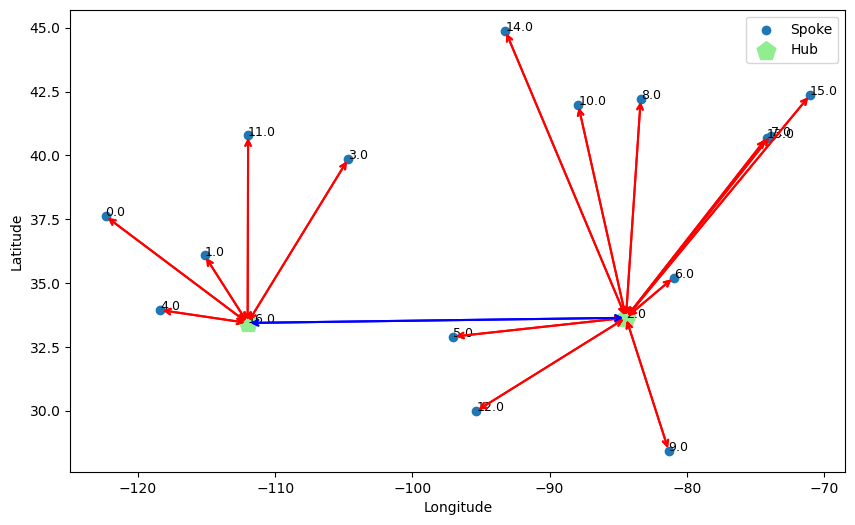

In [24]:
plot_hub_spoke(hub_city_ids2, connections2)

### (c) Vary the number of hubs (K) to 1, 4, and 6, and for each value of K, solve the optimization problem and calculate the total distance traveled by all the packages.

#### Solve the model with 1 hub

In [29]:
hub_city_ids1, connections1 = hub_spoke_network_model(1)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i9-13980HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0xfc31ca34
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 55692 rows and 11271 columns (presolve time = 5s) ...
Presolve removed 401966 rows and 99433 columns
Presolve time: 5.85s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 5.92 seconds (7.40 work units)
Thread count was 1 (of 32 available processors)

Solution count 1: 1.83276e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.832756910952e+07, best bound 1.832756910952e+07, gap 0.0000%
Disca

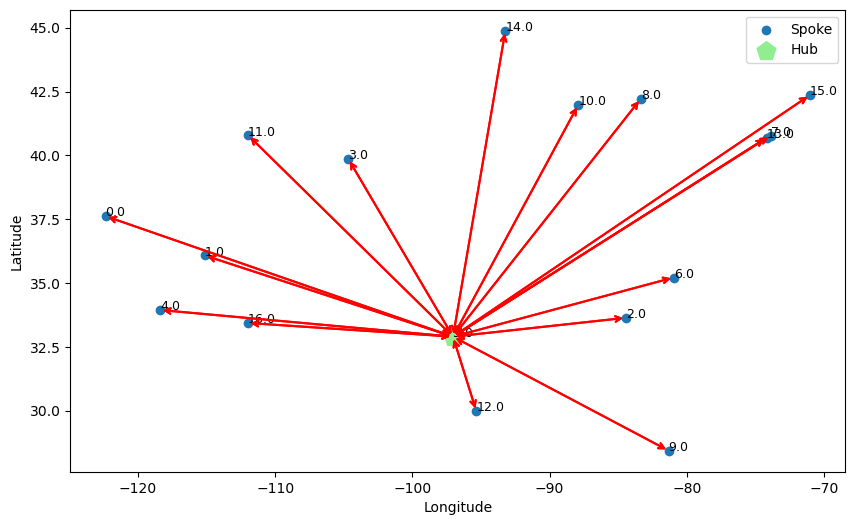

In [30]:
plot_hub_spoke(hub_city_ids1, connections1)

In [27]:
def total_distance_traveled(connections):

    total_distance = 0

    for connection in connections:
        i, j = connection
        distance_ij = d[i][j]  
        packages_ij = f[i][j] 

        total_distance += distance_ij * packages_ij

    return(total_distance)

#### Calculate the total distance with 1 hub

In [28]:
total_distance_traveled1 = total_distance_traveled(connections1)
print('Total distance traveled when there is 1 hub:', total_distance_traveled1)

Total distance traveled when there is 1 hub: 1301773.1626438175


#### Solve the model with 4 hub

In [16]:
hub_city_ids4, connections4 = hub_spoke_network_model(4)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i9-13980HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0xe7cc39d1
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 329971 rows and 24069 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 5.35s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 2.555494e+07
Found heuristic solution: objective 2.264557e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

#### Calculate the total distance with 4 hub

In [17]:
total_distance_traveled4 = total_distance_traveled(connections4)
print('Total distance traveled when there are 4 hubs:', total_distance_traveled4)

Total distance traveled when there are 4 hubs: 1098488.155470701


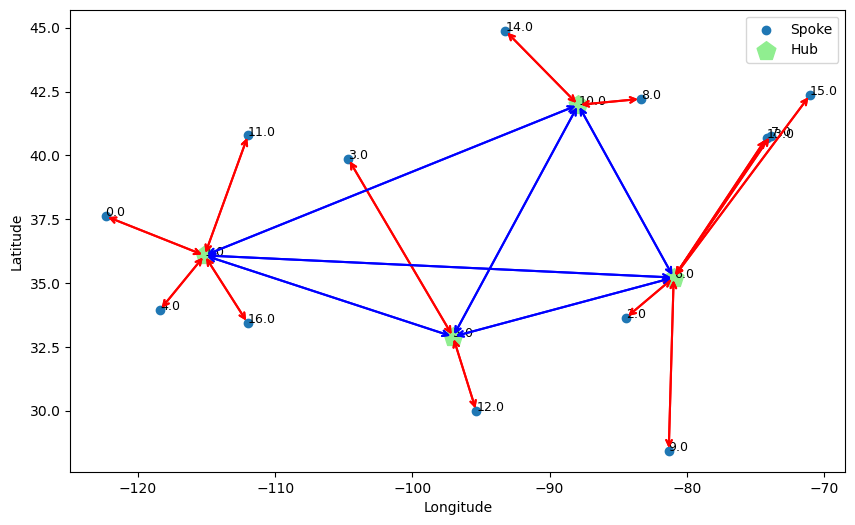

In [44]:
plot_hub_spoke(hub_city_ids4, connections4)

#### Calculate the total distance with 6 hub

In [19]:
hub_city_ids6, connections6 = hub_spoke_network_model(6)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i9-13980HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0x129f8e5d
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 358643 rows and 56927 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 5.12s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 2.450928e+07
Found heuristic solution: objective 2.199534e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

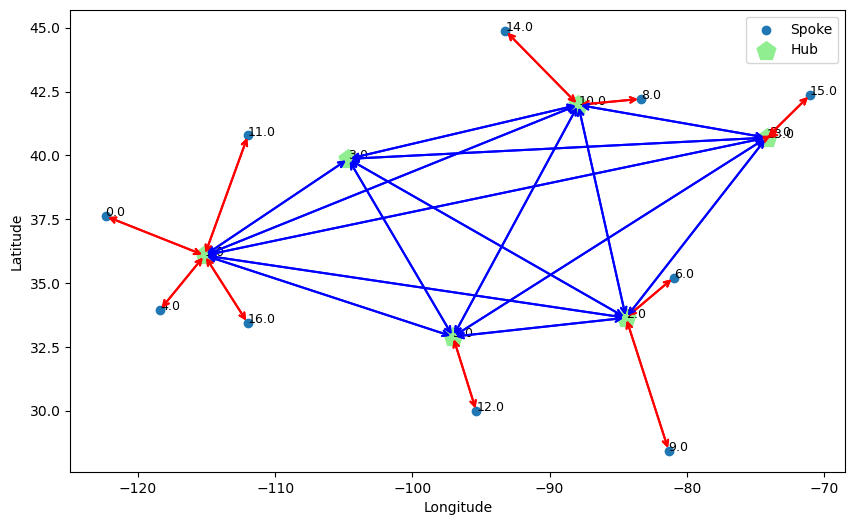

In [45]:
plot_hub_spoke(hub_city_ids6, connections6)

#### Calculate the total distance with 6 hub

In [20]:
total_distance_traveled6 = total_distance_traveled(connections6)
print('Total distance traveled when there are 6 hubs:', total_distance_traveled6)

Total distance traveled when there are 6 hubs: 1941918.378660402


In [244]:
total_distance_traveled2 = total_distance_traveled(connections2)
distances = [total_distance_traveled1,  total_distance_traveled2, 
             total_distance_traveled4, total_distance_traveled6]

num_of_hubs = [1, 2, 4, 6]

plt.plot(num_of_hubs, distances, marker='o')
plt.xlabel('number of hubs')
plt.ylabel('total distance traveled by all packages')
plt.grid(True)
plt.show()

NameError: name 'total_distance_traveled4' is not defined

## Question 3

### (a)

In [23]:
import csv
connections = {
    'connections2': connections2,
    'connections4': connections4,
    'connections6': connections6
}

for name, connection_list in connections.items():
    file_path = f'{name}.csv'
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(connection_list)

In [53]:
import csv

# Function to read connections from a CSV file
def read_connections(file_path):
    connections = []
    with open(file_path, mode='r', encoding='utf-8-sig') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            connections.append(list(map(int, row)))
    return connections

# Correcting the file path variable names
file_path_2 = 'connections2.csv'
file_path_4 = 'connections4.csv'
file_path_6 = 'connections6.csv'

# Initialize empty lists for each connections
connections2 = []
connections4 = []
connections6t = []

# List of file paths and corresponding empty lists
file_paths_and_lists = [
    (file_path_2, connections2),
    (file_path_4, connections4),
    (file_path_6, connections6)
]

# Loop to read each file into its corresponding list
for (file_path, connections_list) in file_paths_and_lists:
    connections_list.extend(read_connections(file_path))

# Now we have three separate lists for connections2, connections4, and connections6
connections2, connections4, connections6


([[0, 16],
  [1, 16],
  [2, 5],
  [2, 6],
  [2, 7],
  [2, 8],
  [2, 9],
  [2, 10],
  [2, 12],
  [2, 13],
  [2, 14],
  [2, 15],
  [2, 16],
  [3, 16],
  [4, 16],
  [5, 2],
  [6, 2],
  [7, 2],
  [8, 2],
  [9, 2],
  [10, 2],
  [11, 16],
  [12, 2],
  [13, 2],
  [14, 2],
  [15, 2],
  [16, 0],
  [16, 1],
  [16, 2],
  [16, 3],
  [16, 4],
  [16, 11]],
 [[0, 1],
  [1, 0],
  [1, 4],
  [1, 5],
  [1, 6],
  [1, 10],
  [1, 11],
  [1, 16],
  [2, 6],
  [3, 5],
  [4, 1],
  [5, 1],
  [5, 3],
  [5, 6],
  [5, 10],
  [5, 12],
  [6, 1],
  [6, 2],
  [6, 5],
  [6, 7],
  [6, 9],
  [6, 10],
  [6, 13],
  [6, 15],
  [7, 6],
  [8, 10],
  [9, 6],
  [10, 1],
  [10, 5],
  [10, 6],
  [10, 8],
  [10, 14],
  [11, 1],
  [12, 5],
  [13, 6],
  [14, 10],
  [15, 6],
  [16, 1]],
 [['0', '1'],
  ['1', '0'],
  ['1', '2'],
  ['1', '3'],
  ['1', '4'],
  ['1', '5'],
  ['1', '10'],
  ['1', '11'],
  ['1', '13'],
  ['1', '16'],
  ['2', '1'],
  ['2', '3'],
  ['2', '5'],
  ['2', '6'],
  ['2', '9'],
  ['2', '10'],
  ['2', '13'],
  ['3', 

In [252]:
from collections import defaultdict

def overhead_cost_average(c, connections, hub_city_ids, package_matrix):
    # Initialize the packages_hub dictionary with zero values for each hub
    packages_hub = {hub_id: 0 for hub_id in hub_city_ids}

    for connection in connections:
        # Determine the hub and spoke of the connection
        hub, spoke = (connection if connection[0] in hub_city_ids else reversed(connection))
        # Add the packages for this connection to the hub's total
        packages_hub[hub] += package_matrix[spoke][hub]

    # Calculate the total overhead cost
    total_cost = sum(packages_hub[hub_id] * c for hub_id in hub_city_ids)

    # Calculate the total number of packages
    total_packages = sum(sum(row) for row in package_matrix)

    # If there are no packages, avoid division by zero by returning 0
    if total_packages == 0:
        return 0

    # Calculate the average overhead cost per package
    average_cost = total_cost / total_packages

    return average_cost, total_cost


In [253]:
c = 100

# when number of hubs == 1
average_cost1, total_cost1 = overhead_cost_average(c, connections1, hub_city_ids1, f)
print('Operational overhead cost per package when there is 1 hub:', average_cost1)

# when number of hubs == 2
average_cost2,total_cost2 = overhead_cost_average(c, connections2, hub_city_ids2, f)
print('Operational overhead cost per package when there are 2 hubs:', average_cost2)

# when number of hubs == 4
average_cost4,total_cost4 = overhead_cost_average(c, connections4, hub_city_ids4, f)
print('Operational overhead cost per package when there are 4 hubs:', average_cost4)

# when number of hubs == 6
average_cost6,total_cost6 = overhead_cost_average(c, connections6, hub_city_ids6, f)
print('Operational overhead cost per package when there are 6 hubs:', average_cost6)

Operational overhead cost per package when there is 1 hub: 13.84975925689207
Operational overhead cost per package when there are 2 hubs: 20.857471558225743


TypeError: 'NoneType' object is not iterable

In [254]:
print(total_cost1)
print(total_cost2)

8126000.0
12237600.0


### (b)

In [256]:
total_operational_overhead_cost = [average_cost1, average_cost2, average_cost4, average_cost6]

NameError: name 'average_cost4' is not defined

In [255]:
plt.plot(num_of_hubs, total_operational_overhead_cost, marker='o')
plt.xlabel('number of hubs')
plt.ylabel('average overhead_cost')
plt.grid(True)
plt.show()

NameError: name 'num_of_hubs' is not defined

We can see that when there are 2 hubs, the average overhead_cost is the lowest, which may inform FreshFarm's decision of setting 2 hubs to avoid extra overhead cost. 

## Question 4

### (a)

In [246]:
d = distance_matrix
f = packages_matrix

def hub_spoke_network_model_cost(v, c):
    
    m = Model("hub_and_spoke")

    # discount factor alpha
    a = 0.75

    # decision variables
    x = m.addVars(cities, cities, vtype = GRB.BINARY, name = "x")  # Spoke-to-Hub and Hub-to-Spoke
    h = m.addVars(cities, cities, vtype = GRB.BINARY, name = "h")  # Hub-to-Hub
    b = m.addVars(cities, vtype = GRB.BINARY, name = "b")  # Hub cities
    e = m.addVars(cities, cities, vtype = GRB.BINARY, name = "e") # Auxiliary variable
    s = m.addVars(cities, cities, cities, vtype = GRB.BINARY, name = "s") # Auxiliary variable
    y = m.addVars(cities, cities, cities, vtype = GRB.BINARY, name = "y")  # Auxiliary variable
    z = m.addVars(cities, cities, cities, cities, vtype = GRB.BINARY, name = "z")  # Auxiliary variable
    w = m.addVars(cities, cities, cities, vtype = GRB.BINARY, name = "w") # Auxiliary variable
    hs = m.addVars(cities, cities, vtype = GRB.BINARY, name = "hs") # Auxiliary variable

    # objective function
    obj = LinExpr()

    # Spoke-to-Hub
    spoke_to_hub = sum(f[i][j] * d[i][j] * e[i,j] for i in range(cities) for j in range(cities))

    # Spoke-to-Hub-to-Hub
    spoke_to_hub_to_hub = sum(f[i][k] * (d[i][j] + a*d[j][k] + c) * s[i,j,k] for i in range(cities) for j in range(cities) for k in range(cities))
    
    # Spoke-to-Hub-to-Spoke
    spoke_to_hub_to_spoke = sum(f[i][k] * (d[i][j] + d[j][k] + c) * y[i,j,k] for i in range(cities) for j in range(cities) for k in range(cities))

    # Spoke-to-Hub-to-Hub-to-Spoke
    spoke_to_hub_to_hub_to_spoke = sum(f[i][l] * (d[i][j] + a*d[j][k] + d[k][l] + 2*c) * z[i,j,k,l] for i in range(cities) for j in range(cities) for k in range(cities) for l in range(cities))

    # Hub-to-Hub
    hub_to_hub = sum(f[i][j] * d[i][j] * a * h[i,j] for i in range(cities) for j in range(cities))

    # Hub-to-Spoke
    hub_to_spoke = sum(f[j][i] * d[j][i] * hs[j,i] for i in range(cities) for j in range(cities))
    
    # Hub-to-Hub_to_Spoke
    hub_to_hub_to_spoke = sum(f[i][k] * (a*d[i][j] + d[j][k] +c ) * w[i,j,k] for i in range(cities) for j in range(cities) for k in range(cities))

    # Total objective ########
    obj =  spoke_to_hub + spoke_to_hub_to_hub + spoke_to_hub_to_spoke + hub_to_hub + hub_to_spoke + spoke_to_hub_to_hub_to_spoke + hub_to_hub_to_spoke

    m.setObjective(obj, GRB.MINIMIZE)
    
 ### constraints

    # Ensure two-direction Connections
    for i in range(cities):
        for j in range(cities):
            if i != j:
                m.addConstr(x[i,j] == x[j,i])
                m.addConstr(h[i,j] == h[j,i])

    # Constrain on general connection
    for i in range(cities):
        for j in range(cities):
            m.addConstr(x[i,i] == 0)  # Ensure there is no connection between a city and it self
            m.addConstr(x[i,j] <= b[i] + b[j])  # Ensure there will be no connection between spoke and spoke        

    # Constrain on Spoke to Hub          
    for i in range(cities):
        m.addConstr(sum(e[i,j] for j in range(cities)) >= (1 - b[i])) # Ensure every spoke i will connect to only one hub city
        for j in range(cities):
            m.addConstr(e[i,j] <= x[i,j])
            m.addConstr(e[i,j] <= b[j])
            m.addConstr(e[i,j] >= x[i,j] + b[j] - 1)
            m.addConstr(e[i,j] >= 0)
    # Constraint for hub-to-spoke connections
    for i in range(cities):
        for j in range(cities):
            m.addConstr(hs[j,i] <= x[j,i])
            m.addConstr(hs[j,i] <= b[j])
            m.addConstr(hs[j,i] >= x[j,i] + b[j] - 1)
    
                    
    # Spoke-to-Hub-to-Hub Connection Constraints                 
    for i in range(cities):
        for j in range(cities):
            for k in range(cities):
                # Ensure that if there is a route from spoke i to hub j and then to hub k, city i must be a spoke
                m.addConstr(s[i,j,k] <= x[i,j])
                m.addConstr(s[i,j,k] <= h[j,k])
                m.addConstr(s[i,j,k] <= (1 - b[i]))  # Ensure i is a spoke
                # The following constraint ensures that spoke-to-hub-to-hub routing is valid only if the spoke-to-hub and hub-to-hub connections are true, and i is a spoke
                m.addConstr(s[i,j,k] >= x[i,j] + h[j,k] + (1 - b[i]) - 2)

    # Hub-to-Hub-to-Spoke Connection Constraints
    for i in range(cities):
        for j in range(cities):
            for k in range(cities):
                m.addConstr(w[i,j,k] <= h[i,j])
                m.addConstr(w[i,j,k] <= x[j,k])
                m.addConstr(w[i,j,k] <= b[i])  # Ensure i is a hub
                m.addConstr(w[i,j,k] <= b[j])  # Ensure j is a hub
                m.addConstr(w[i,j,k] >= h[i,j] + x[j,k] + b[i] + b[j] - 3)
                

    
    
    # Hub constraints
    for i in range(cities):
        m.addConstr(x[i,i] == 0)  # A city cannot connect to itself

        # Ensure each spoke has at least one connection to a hub
        m.addConstr(sum(e[i,j] for j in range(cities)) >= (1 - b[i]))

        for j in range(cities):
            if i != j:
                m.addConstr(h[i,j] <= b[i])
                m.addConstr(h[i,j] <= b[j])
                m.addConstr(h[i,j] >= b[i] + b[j] - 1)
            for k in range(cities):
                m.addConstr(y[i,j,k] <= x[i,j])
                m.addConstr(y[i,j,k] <= x[j,k])
                m.addConstr(y[i,j,k] <= b[j])
                m.addConstr(y[i,j,k] >= x[i,j] + x[j,k] + b[j] - 2)
                for l in range(cities):
                    m.addConstr(z[i,j,k,l] <= x[i,j])
                    m.addConstr(z[i,j,k,l] <= h[j,k])
                    m.addConstr(z[i,j,k,l] <= x[k,l])
                    m.addConstr(z[i,j,k,l] >= x[i,j] + h[j,k] + x[k,l] - 2)

    # set the number of hubs = v
    m.addConstr(sum(b[i] for i in range(cities)) == v)

    m.optimize()
    
    # check feasibility
    if m.status != GRB.Status.OPTIMAL:
        print("Infeasible")
        m.computeIIS()
        return None, None
    
    else: 
        # extract hub city id
        hub_city_ids = [i for i in range(cities) if b[i].x == 1]

        # extract connections
        connections = [[i, j] for i in range(cities) for j in range(cities) if (x[i,j].x == 1 or h[i,j].x == 1)]

    # reset the model
    m.reset()

    return hub_city_ids, connections

(b)

In [43]:
hub_city_ids_cost5, connections_cost5 = hub_spoke_network_model_cost(2, 5)
total_distance_traveled_cost5 = total_distance_traveled(connections_cost5)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i9-13980HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0xae43b1e6
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 8e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 89196 rows and 19689 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 5.85s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 2.882499e+07
Found heuristic solution: objective 2.602929e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...



total distance traveled with cost 5: 1236255.9238509636



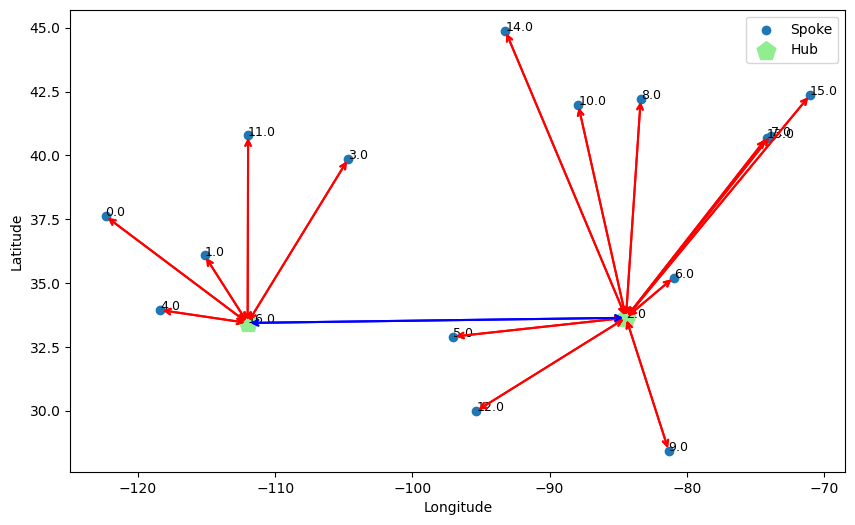

In [47]:
print()
print(f"total distance traveled with cost 5: {total_distance_traveled_cost5}")
print()
plot_hub_spoke(hub_city_ids_cost5, connections_cost5)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0xdf7ae133
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 8e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 54876 rows and 10999 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 8.65s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 2.882499e+07
Found heuristic solution: objective 2.602929e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      

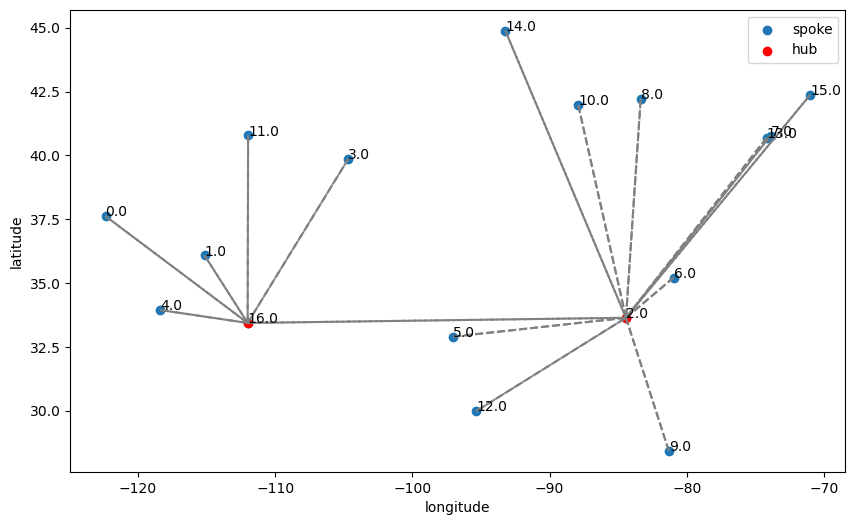

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0x3a663dfd
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 9e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 54876 rows and 10999 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 8.19s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 3.144383e+07
Found heuristic solution: objective 2.858090e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      

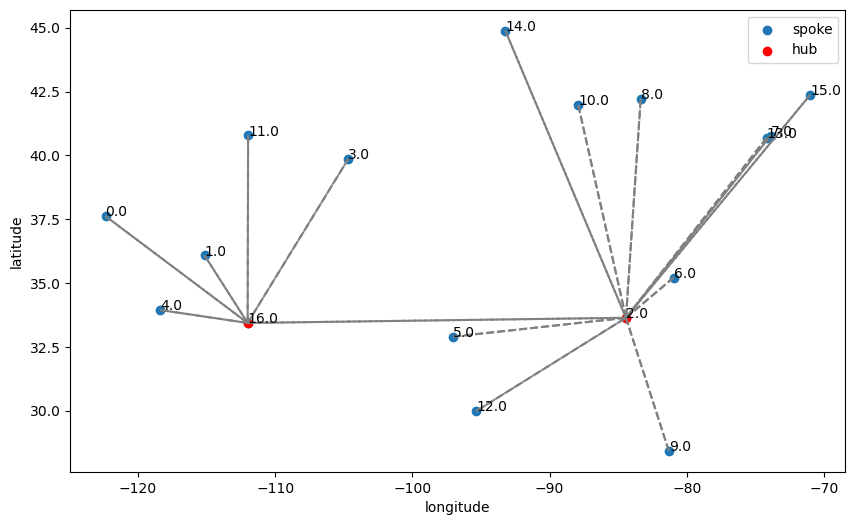

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0x33d025d0
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 54876 rows and 10999 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 7.98s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 3.668150e+07
Found heuristic solution: objective 3.368411e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      

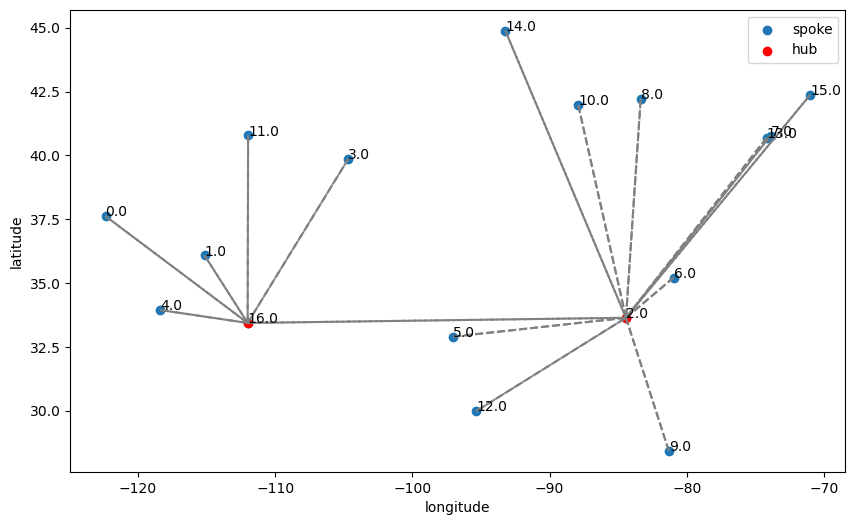

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0xb17aedab
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 54876 rows and 10999 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 8.35s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 4.715684e+07
Found heuristic solution: objective 4.389053e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      

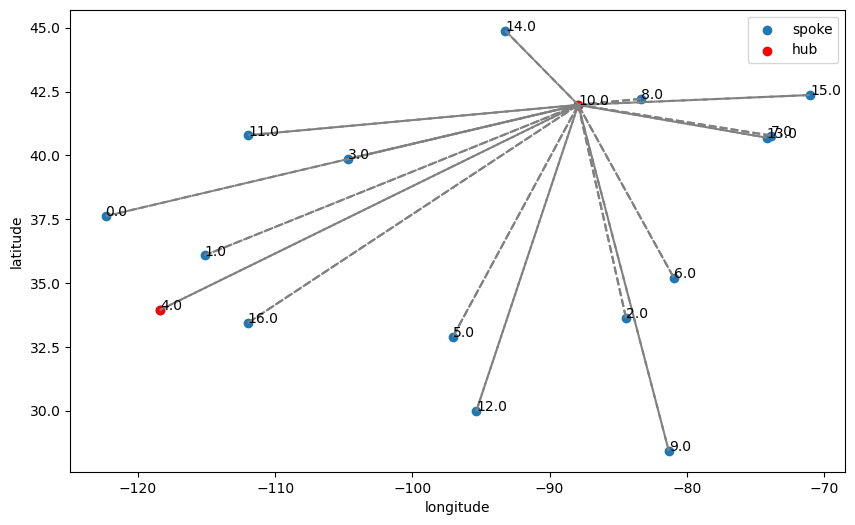

In [247]:
costs = [5,10,20,40]

for cost in costs:
    hub_city_ids, connections = hub_spoke_network_model_cost(2, cost)
    total_distance = total_distance_traveled(connections)
    print(f"\nTotal distance traveled with cost {cost}: {total_distance}\n")
    plot_hub_spoke(hub_city_ids, connections)

### Analysis of Overhead Costs and Network Configuration
#### In addressing this issue, we set overhead costs to be 5, 10, 20, and 40. We observed that when the overhead costs were 5, 10, or 20 units, the transportation network configuration remained the same. This is because that the savings from shorter travel distances outweighed the overhead costs. 

#### However, after increased the overhead cost to 40 units, the model chose cities 4 and 10 as hub cities. Under these circumstances, all spoke cities were connected to the hub city 10, tring to minimize the number of intermediate stops. Consequently, the total distance traveled by all packages increased from 1,236,255.92 to 1,710,117.49 units. This adjustment was a tradeoff between the cost transportation and the overhead cost.

## Question 5

#### Based on the analysis results of the question, we can tell that, high operations costs may result in some companies reducing the number of intermediate stops or just keeping a direct distance in their operation. 
### However, using direct routes will cause a lot of problems, especially for the large-scale network transportation of FreshFarm’s products. In their daily operation, if they choose to use direct transportation, they will have to keep, maintain, and arrange a huge amount of transportation routes. It will need a large-scale management team to handle its transportation issues and make planning for each day’s transportation. And increase the cost of recruiting drivers and purchasing trucks to carry out their daily transportation. 
#### Compared with other transportation models, the hub and spoke model will reduce the amount transportation routes and the frequencies of transportation required. You can combine some transportation of the products and transport them in large patches, which will enable you to reduce the waste of transportation capacity when you don’t have enough products to fill the whole truck. Also, it will enable the company to benefit from the scale economic, using larger vehicles. This will reduce the transportation cost per package. Another unique of the hub and spoke model is that it is expandable. When you want to add a city to your network, you can just connect it to the nearest hub city and establish a small-scale transportation route to transport products for it. It is easier to maintain and manage. 
#### The spoke-hub model also has some advantages when transporting perishable goods. These perishable goods will need special storage methods when they are transported, like refrigerated trucks and refrigerated warehouses and they are expensive to maintain and operate. In the hub-spoke model, we can apply these methods only when these products are transported over long distances, like from hub to hub. Just use regular warehouses and trucks when they are transported from hub to spoke or spoke to hub since the distance would be closer. Through this, companies could save a lot of money since they don’t have to keep a lot of refrigerated warehouses or use refrigerated trucks for every route. 
